<h3>Forex Prediction: Recursive Neural Networks (RNNs)

In [23]:
import pandas as pd
import numpy as np
from data_functions import *
import matplotlib.pyplot as plt

In [2]:
all_data, cc_dict, countries =load_and_process_forex_data()
all_data.head()

,Date,EURO/US$,UNITED KINGDOM POUND/US$,YEN/US$,YUAN/US$,AUSTRALIAN DOLLAR/US$
0,2000-01-03,0.9847,0.6146,101.70,8.2798,1.5172
1,2000-01-04,0.9700,0.6109,103.09,8.2799,1.5239
2,2000-01-05,0.9676,0.6092,103.77,8.2798,1.5267
3,2000-01-06,0.9686,0.6070,105.19,8.2797,1.5291
4,2000-01-07,0.9714,0.6104,105.17,8.2794,1.5272


In [3]:
def create_data_dict_currency(data,countries,currency_dict):

    def extract_currency_data(data, currency):
            """
            Extract a specific country's data from the main dataframe.
            
            Parameters:
            data (DataFrame): The main dataframe containing all countries' data
            country_name (str): The name of the country to extract data for
            
            Returns:
            DataFrame: A dataframe containing only the specified country's data with date column
            """
            country_data = data[['Date',currency]].copy()
            
            # Ensure date column is included and properly formatted
            
            return country_data

    data_dict = {}
    for country in countries:
        data_dict[currency_dict[country]] = extract_currency_data(data,currency_dict[country])
    
    return data_dict    

In [4]:
# Create a dictionary of dataframes of each currency
data_dict = create_data_dict_currency(all_data,countries,cc_dict)
data_dict['EURO/US$']

,Date,EURO/US$
0,2000-01-03,0.9847
1,2000-01-04,0.9700
2,2000-01-05,0.9676
3,2000-01-06,0.9686
4,2000-01-07,0.9714
...,...,...
5211,2019-12-24,0.9022
5213,2019-12-26,0.9007
5214,2019-12-27,0.8949
5215,2019-12-30,0.8915


<h5>Pre-processing to carry out:</h5>


- Train-test split.
- Scaling (will use a RobustScaler()). Fit_transform on train, and transform on test.
- Time window creation.


N.B. Save the scalers used for each currency to be used for data preparation and inversion when using the model in the app (as pickle files).

In [5]:
# Train-test splitting (non-random, last 60 rows are taken as the test). Will focus on EUR now:
df = data_dict['EURO/US$'].copy()
if 'Date' in df.columns:
    df = df.sort_values('Date').reset_index(drop=True)

test_df = df.tail(60).reset_index(drop=True)
train_df = df.iloc[:-60].reset_index(drop=True)

In [6]:
from sklearn.preprocessing import RobustScaler

def robust_scale_train_test(train_df, test_df, drop_date=True):
    """
    Fit RobustScaler on train_df (drop Date column if present) and transform both train and test.
    Returns: scaler, train_scaled_df, test_scaled_df
    """
    if drop_date and 'Date' in train_df.columns:
        X_train = train_df.drop(columns=['Date']).copy()
    else:
        X_train = train_df.copy()
    if drop_date and 'Date' in test_df.columns:
        X_test = test_df.drop(columns=['Date']).copy()
    else:
        X_test = test_df.copy()

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)

    train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return scaler, train_scaled_df, test_scaled_df

In [7]:
eur_scaler, train_scaled_df, test_scaled_df = robust_scale_train_test(train_df,test_df)

In [8]:
# Create windows for an LSTM model:
def LSTM_input(df, input_sequence):
    """
    Generate supervised learning sequences from a time-ordered dataset
    for one-step-ahead LSTM forecasting.

    This function converts a time-series DataFrame into sliding input
    sequences (X) and corresponding target values (y), suitable for
    training a many-to-one LSTM model.

    For each sample:
        - X contains `input_sequence` consecutive past observations
        - y contains the immediately following observation

    The function assumes the data is:
        - Ordered in ascending chronological order (oldest → newest)
        - Free of non-numeric columns (e.g. time columns removed)
        - Already scaled or normalised, if required

    Parameters
    ----------
    df : pandas.DataFrame
        Time-series data containing one or more numeric features.
        Shape: (n_samples, n_features).
        The index or original time column is not used by this function.

    input_sequence : int
        Number of past time steps to include in each input sequence
        (i.e. the LSTM lookback window).

    Returns
    -------
    X : numpy.ndarray
        Array of input sequences with shape:
            (n_samples - input_sequence, input_sequence, n_features)

    y : numpy.ndarray
        Array of target values with shape:
            (n_samples - input_sequence, n_features)

    Notes
    -----
    - This function performs one-step-ahead forecasting.
    - Each target value corresponds to the time step immediately
      following its input sequence.
    - The function does not shuffle data and preserves temporal order.
    - The function does not perform any scaling or missing-value handling.

    Example
    -------
    >>> X, y = Sequential_Input_LSTM(df_scaled, input_sequence=28)
    >>> X.shape
    (num_samples, 28, num_features)
    >>> y.shape
    (num_samples, num_features)
    """
    df_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)
        
    return np.array(X), np.array(y)

In [9]:
# Generate the windowed train and test (scaled) data:
train_windowed_X, train_windowed_y = LSTM_input(train_scaled_df,10)
test_windowed_X, test_windowed_y = LSTM_input(test_scaled_df, 10)

In [10]:
# Data is now split and preprocessed ready for modelling.

<h5>Modelling

- Will create an optimise a model for the EUR/USD set and then train the same type of model on the other currencies.

- Will use a temporal split for the validation instead of just creating a validation set (from the training set, manually) and providing it i.e. I will define a fraction (of the last rows) that will be taken by the model for validation from the training set. Validation isn't a necessity but it is useful for model evaluation.

- Will start with a single LSTM layer and then add more layers if evaluation shows that it is necessary.

In [11]:
import tensorflow as tf
# Check if the GPU is being used:
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
# Import others:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

TF version: 2.20.0
GPUs: []


In [12]:
# May need to do training on the PC (not mac) as the training speed is poor on mac. Cunrrently running
# python 3.12 which isn't compatiable with tensorflow-metal (allows GPU training on the Mac M3 chip).

In [ ]:
import matplotlib.pyplot as plt

In [27]:
# Starting with a single LSTM layer model

X_train = train_windowed_X
y_train = train_windowed_y

lookback_length = X_train.shape[1] # Should be 10 here.
features = X_train.shape[2] # Should be 1 here.

print(lookback_length)
print(features)

eur_model_1 = keras.Sequential([
    keras.layers.Input(shape=(lookback_length,features)),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='linear')
])

eur_model_1.summary()

# Early stopping to reduce overfitting:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

eur_model_1.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()]
)

eur_model_1_history = eur_model_1.fit(
    X_train, y_train,
    validation_split=0.1,  # temporal split: last 10% of training used for validation
    epochs=100,
    batch_size=128,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

10
1


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3562 - root_mean_squared_error: 0.5968 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - root_mean_squared_error: 0.1402 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182 - root_mean_squared_error: 0.1350 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

In [25]:
# Validation curve output functionality
def plot_training_history(history):
    # Accept either History object or dict
    hist = history.history if hasattr(history, "history") else history
    epochs = range(1, len(hist.get("loss", [])) + 1)

    plt.figure(figsize=(12, 4))

    # Loss subplot
    plt.subplot(1, 2, 1)
    if "loss" in hist:
        plt.plot(epochs, hist["loss"], label="train_loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Metric subplot: pick first non-loss metric (and its val counterpart if present)
    metric_keys = [k for k in hist.keys() if k not in ("loss", "val_loss")]
    if metric_keys:
        # choose a training metric (prefer non-val)
        train_metric = next((k for k in metric_keys if not k.startswith("val_")), metric_keys[0])
        val_metric = f"val_{train_metric}" if f"val_{train_metric}" in hist else None

        plt.subplot(1, 2, 2)
        plt.plot(epochs, hist[train_metric], label=f"train_{train_metric}")
        if val_metric:
            plt.plot(epochs, hist[val_metric], label=f"val_{train_metric}")
        plt.xlabel("Epoch")
        plt.ylabel(train_metric)
        plt.title("Training and Validation Metric")
        plt.legend()

    plt.tight_layout()
    plt.show()

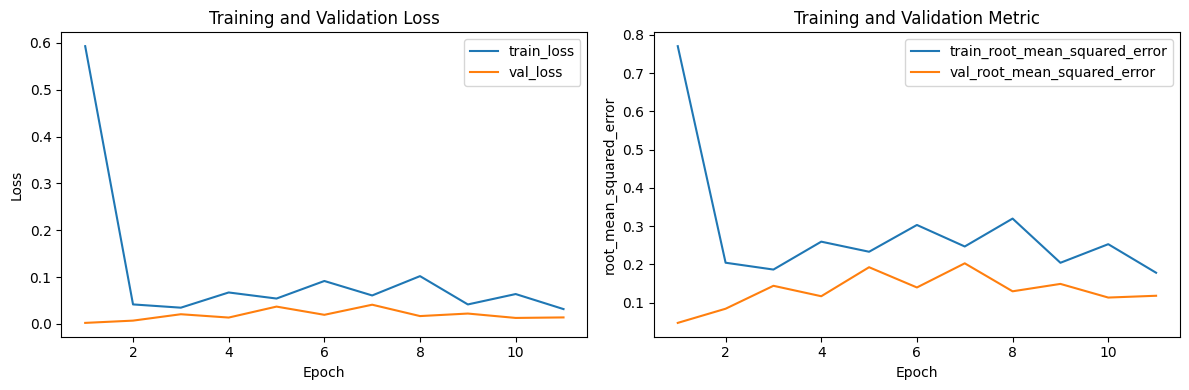

In [26]:
# Euro model 1 plot:
plot_training_history(eur_model_1_history) #Single 64-layer

In [30]:
# 2 Layers:
eur_model_2 = keras.Sequential([
    keras.layers.Input(shape=(lookback_length,features)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='linear')
])

eur_model_2.summary()

# Early stopping to reduce overfitting:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

eur_model_2.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()]
)

eur_model_2_history = eur_model_2.fit(
    X_train, y_train,
    validation_split=0.1,  # temporal split: last 10% of training used for validation
    epochs=100,
    batch_size=128,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5239 - root_mean_squared_error: 0.7238 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1452
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0873 - root_mean_squared_error: 0.2955 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1821
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0430 - root_mean_squared_error: 0.2074 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1616
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

In [34]:
# 3 Layers:
eur_model_3 = keras.Sequential([
    keras.layers.Input(shape=(lookback_length,features)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='linear')
])

eur_model_3.summary()

# Early stopping to reduce overfitting:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

eur_model_3.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()]
)

eur_model_3_history = eur_model_3.fit(
    X_train, y_train,
    validation_split=0.1,  # temporal split: last 10% of training used for validation
    epochs=100,
    batch_size=128,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5570 - root_mean_squared_error: 0.7463 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0625 - root_mean_squared_error: 0.2500 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0555 - root_mean_squared_error: 0.2356 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0515
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

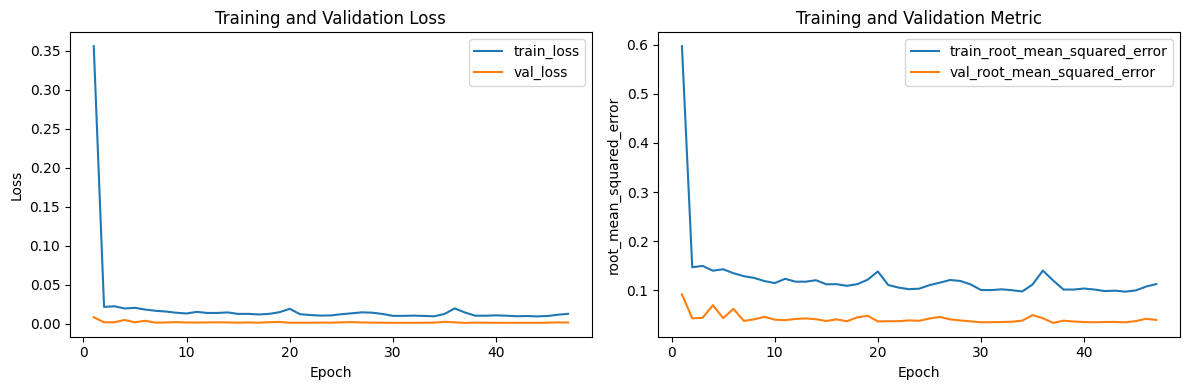

In [32]:
# EUR Model 1:
plot_training_history(eur_model_1_history)

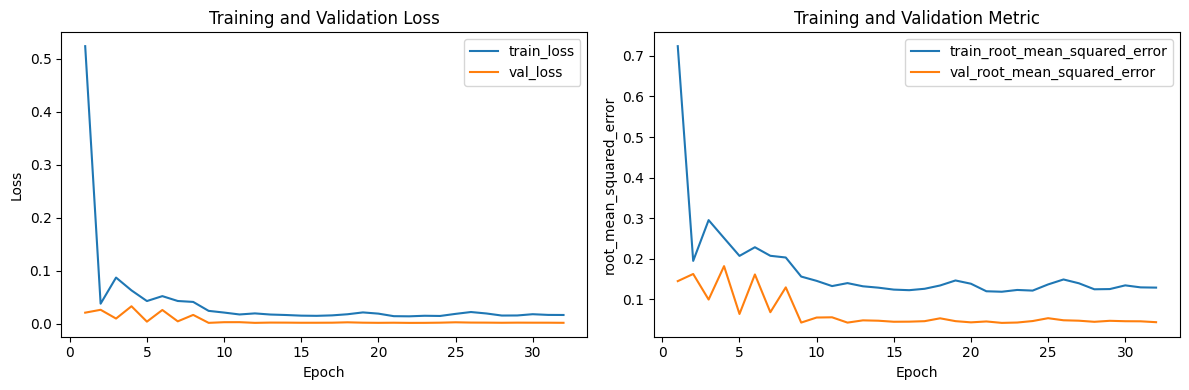

In [31]:
# EUR Model 2:
plot_training_history(eur_model_2_history)

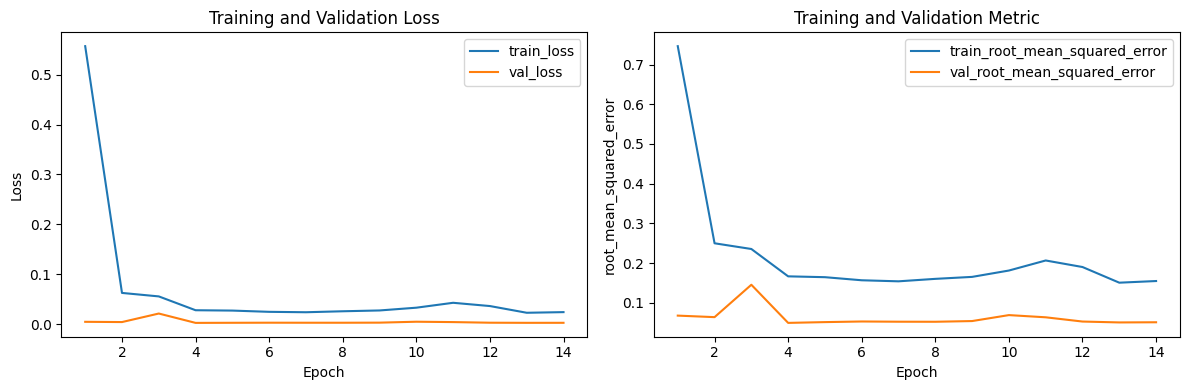

In [35]:
# EUR Model 3:
plot_training_history(eur_model_3_history)

In [37]:
# No signs of overfitting so far (validation remains below training in loss and error).
# Will use the 3 layer model in the streamlit app.

In [42]:
# The other data sets: data_dict
# Generated by doing: 

#   all_data, cc_dict, countries =load_and_process_forex_data()
#   data_dict = create_data_dict_currency(all_data,countries,cc_dict)   

# So to return AUSTRALIAN DOLLAR:
data_dict[cc_dict['AUSTRALIA']]

,Date,AUSTRALIAN DOLLAR/US$
0,2000-01-03,1.5172
1,2000-01-04,1.5239
2,2000-01-05,1.5267
3,2000-01-06,1.5291
4,2000-01-07,1.5272
...,...,...
5211,2019-12-24,1.4445
5213,2019-12-26,1.4411
5214,2019-12-27,1.4331
5215,2019-12-30,1.4278


In [45]:
# Function to do the splitting and preprocessing, and generate the scalers:

def preprocess_all_data_rnn(all_data, cc_dict, countries):

    data_dict = create_data_dict_currency(all_data,countries,cc_dict)

    scaler_dict = {}
    training_dict = {}
    testing_dict = {}

    for country in countries:

        currency = cc_dict[country]

        df = data_dict[currency].copy()
        if 'Date' in df.columns:
            df = df.sort_values('Date').reset_index(drop=True)

        test_df = df.tail(60).reset_index(drop=True)
        train_df = df.iloc[:-60].reset_index(drop=True)

        scaler, train_scaled_df, test_scaled_df = robust_scale_train_test(train_df,test_df)

        train_windowed_X, train_windowed_y = LSTM_input(train_scaled_df,10)
        test_windowed_X, test_windowed_y = LSTM_input(test_scaled_df, 10)

        # store scaler and windowed data for this currency
        scaler_dict[currency] = scaler
        training_dict[currency] = {'X': train_windowed_X, 'y': train_windowed_y}
        testing_dict[currency] = {'X': test_windowed_X, 'y': test_windowed_y}
    
    return scaler_dict,training_dict,testing_dict

In [ ]:
# Allow old imported scalers to be used:

def preprocess_all_data_rnn_os(all_data, cc_dict, countries, prefit_scalers: dict = None):
    """
    Create windowed train/test datasets per currency using provided pre-fitted RobustScalers.
    If a scaler for a currency is not provided in `prefit_scalers`, a new RobustScaler will be fit.
    Returns: training_dict, testing_dict
    """
    data_dict = create_data_dict_currency(all_data, countries, cc_dict)

    training_dict = {}
    testing_dict = {}

    for country in countries:
        currency = cc_dict[country]

        df = data_dict[currency].copy()
        if "Date" in df.columns:
            df = df.sort_values("Date").reset_index(drop=True)

        test_df = df.tail(60).reset_index(drop=True)
        train_df = df.iloc[:-60].reset_index(drop=True)

        # drop Date column before scaling if present
        if "Date" in train_df.columns:
            X_train_raw = train_df.drop(columns=["Date"]).copy()
        else:
            X_train_raw = train_df.copy()
        if "Date" in test_df.columns:
            X_test_raw = test_df.drop(columns=["Date"]).copy()
        else:
            X_test_raw = test_df.copy()

        # use provided pre-fitted scaler if available, otherwise fit a new one
        if prefit_scalers is not None and currency in prefit_scalers and prefit_scalers[currency] is not None:
            scaler = prefit_scalers[currency]
            X_train_scaled = scaler.transform(X_train_raw.values)
            X_test_scaled = scaler.transform(X_test_raw.values)
        else:
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw.values)
            X_test_scaled = scaler.transform(X_test_raw.values)

        train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns, index=X_train_raw.index)
        test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns, index=X_test_raw.index)

        train_windowed_X, train_windowed_y = LSTM_input(train_scaled_df, 10)
        test_windowed_X, test_windowed_y = LSTM_input(test_scaled_df, 10)

        training_dict[currency] = {"X": train_windowed_X, "y": train_windowed_y}
        testing_dict[currency] = {"X": test_windowed_X, "y": test_windowed_y}

    return training_dict, testing_dict


In [46]:
scaler_dict,training_dict,testing_dict = preprocess_all_data_rnn(all_data,cc_dict,countries)

In [48]:
scaler_dict['UNITED KINGDOM POUND/US$']

,"with_centering with_centering: bool, default=TrueIf `True`, center the data before scaling.This will cause :meth:`transform` to raise an exception when attemptedon sparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_scaling with_scaling: bool, default=TrueIf `True`, scale the data to interquartile range.",True
,"quantile_range quantile_range: tuple (q_min, q_max), 0.0 < q_min < q_max < 100.0, default=(25.0, 75.0)Quantile range used to calculate `scale_`. By default this is equal tothe IQR, i.e., `q_min` is the first quantile and `q_max` is the thirdquantile... versionadded:: 0.18","(25.0, ...)"
,"copy copy: bool, default=TrueIf `False`, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"unit_variance unit_variance: bool, default=FalseIf `True`, scale data so that normally distributed features have avariance of 1. In general, if the difference between the x-values of`q_max` and `q_min` for a standard normal distribution is greaterthan 1, the dataset will be scaled down. If less than 1, the datasetwill be scaled up... versionadded:: 0.24",False


In [49]:
# Save the scalers to pkl files for later import:

import os
import re
import pickle
from typing import Dict

def save_rnn_scalers(scaler_dict: dict, out_dir: str = "rnn_scalers") -> Dict[str, str]:
    """
    Save scalers from scaler_dict to pickle files in out_dir.
    Returns a dict mapping currency -> saved filepath.
    """
    os.makedirs(out_dir, exist_ok=True)
    saved_map: Dict[str, str] = {}
    for currency, scaler in scaler_dict.items():
        safe_name = re.sub(r"[^\w\-.()]", "_", currency)
        fname = f"{safe_name}_scaler.pkl"
        path = os.path.join(out_dir, fname)
        with open(path, "wb") as f:
            pickle.dump(scaler, f, protocol=pickle.HIGHEST_PROTOCOL)
        saved_map[currency] = path
    return saved_map

In [50]:
scaler_paths = save_rnn_scalers(scaler_dict)

In [52]:
scaler_paths
# Very important that this is kept record and placed in the streamlit app...

{'EURO/US$': 'rnn_scalers\\EURO_US__scaler.pkl',
 'UNITED KINGDOM POUND/US$': 'rnn_scalers\\UNITED_KINGDOM_POUND_US__scaler.pkl',
 'YEN/US$': 'rnn_scalers\\YEN_US__scaler.pkl',
 'YUAN/US$': 'rnn_scalers\\YUAN_US__scaler.pkl',
 'AUSTRALIAN DOLLAR/US$': 'rnn_scalers\\AUSTRALIAN_DOLLAR_US__scaler.pkl'}

In [53]:
def train_rnn_models(
    training_dict,
    lookback=lookback_length,
    features=features,
    units=64,
    layers=3,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=0,
):
    """
    Train an RNN (stacked LSTM) per currency using training_dict.
    Returns: dict currency -> fitted keras model
    """
    models = {}
    for currency, data in training_dict.items():
        X = data["X"]
        y = data["y"]

        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(lookback, features)))

        # Add LSTM layers (all but last return_sequences=True)
        for i in range(layers):
            return_seq = True if i < (layers - 1) else False
            model.add(keras.layers.LSTM(units, return_sequences=return_seq))
            model.add(keras.layers.Dropout(0.3))

        model.add(keras.layers.Dense(1, activation="linear"))

        model.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(learning_rate=0.001),
            metrics=[RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        model.fit(
            X,
            y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            callbacks=[es],
            verbose=verbose,
        )

        models[currency] = model

    return models

In [60]:
fitted_models = train_rnn_models(training_dict, epochs=100, verbose=0)

In [55]:
fitted_models

{'EURO/US$': <Sequential name=sequential_25, built=True>,
 'UNITED KINGDOM POUND/US$': <Sequential name=sequential_26, built=True>,
 'YEN/US$': <Sequential name=sequential_27, built=True>,
 'YUAN/US$': <Sequential name=sequential_28, built=True>,
 'AUSTRALIAN DOLLAR/US$': <Sequential name=sequential_29, built=True>}

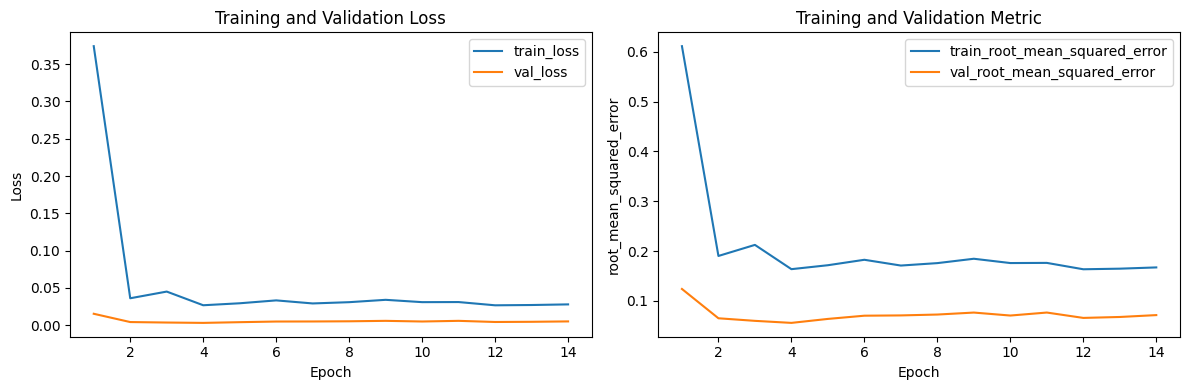

In [61]:
australian_model = fitted_models[cc_dict['AUSTRALIA']]
# See the validation curve:
plot_training_history(australian_model.history)

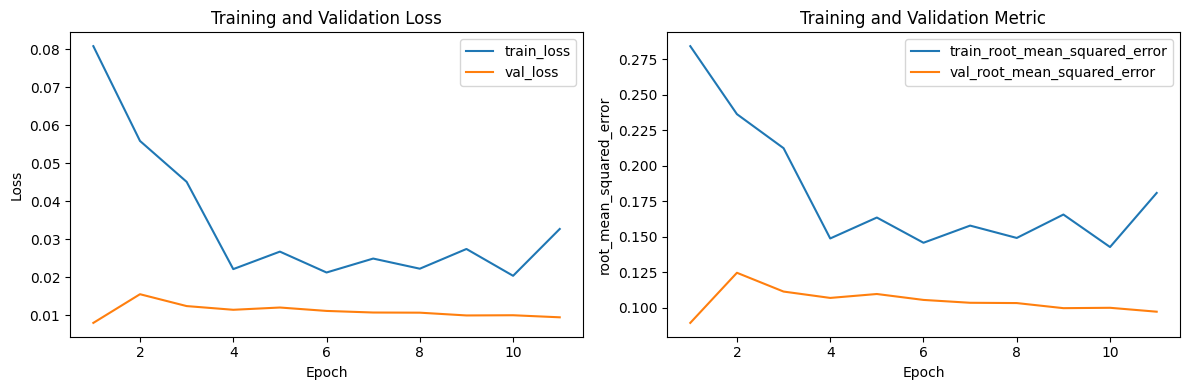

In [62]:
uk_model = fitted_models[cc_dict['UNITED KINGDOM']]
# See the validation curve:
plot_training_history(uk_model.history)

In [63]:
# Save the models:
import pickle
import os

def save_trained_rnn_models(trained_models_dict, save_directory="models"):
    """
    Save trained Keras RNN models to pickle files.
    
    Parameters:
    -----------
    trained_models_dict : dict
        Dictionary containing trained models with currency names as keys
    save_directory : str, default="models"
        Directory to save the model files
    
    Returns:
    --------
    dict: Dictionary mapping currency names to their saved file paths
    """
    
    # Create directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    saved_files = {}
    
    for currency_name, model in trained_models_dict.items():
        # Clean currency name for filename (replace special characters)
        clean_name = currency_name.replace("/", "_").replace("$", "").replace(" ", "_")
        filename = f"{clean_name}_rnn_model.pkl"
        filepath = os.path.join(save_directory, filename)
        
        # Save model using pickle
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        
        saved_files[currency_name] = filepath
        print(f"Saved {currency_name} model to {filepath}")sa

    return saved_files

In [64]:
saved_rnn_models = save_trained_rnn_models(fitted_models)
saved_rnn_models

Saved EURO/US$ model to models\EURO_US_rnn_model.pkl
Saved UNITED KINGDOM POUND/US$ model to models\UNITED_KINGDOM_POUND_US_rnn_model.pkl
Saved YEN/US$ model to models\YEN_US_rnn_model.pkl
Saved YUAN/US$ model to models\YUAN_US_rnn_model.pkl
Saved AUSTRALIAN DOLLAR/US$ model to models\AUSTRALIAN_DOLLAR_US_rnn_model.pkl


{'EURO/US$': 'models\\EURO_US_rnn_model.pkl',
 'UNITED KINGDOM POUND/US$': 'models\\UNITED_KINGDOM_POUND_US_rnn_model.pkl',
 'YEN/US$': 'models\\YEN_US_rnn_model.pkl',
 'YUAN/US$': 'models\\YUAN_US_rnn_model.pkl',
 'AUSTRALIAN DOLLAR/US$': 'models\\AUSTRALIAN_DOLLAR_US_rnn_model.pkl'}

<h5>Forecasting Functionality:

Things needed for forecasting in the streamlit app:
- A way to load the model from a pkl file.
- For 'execute_rnn()', a way to use the model, processed data (i.e. windowed) for a single currency, and a defined forecast length.
- The processed data (windowed) should be generated when the app.py is first run. A function to generate windowed data for all currencies should be run in the 'if __name__ == etc.. ' block. Call it something similar to this:

    xgbdata_raw = create_data_dict_currency_xgboost(data,country_names,country_currency_dict)
    xgbdata_processed = process_all_xgboost(xgbdata_raw)

In [ ]:
def incremental_forecast_to_df(
    model,
    train_X,
    train_y,
    lookback=10,
    horizon=60,
    scaler=None,
    start_step=1,
    column_name="forecast",
):
    """
    Incremental (recursive) forecasting for a univariate (or multivariate) windowed TF RNN model (single currency)

    Requires:
      - train_X: windowed 3D array (n_windows, lookback, n_features). The last window is used as history.
      - train_y: corresponding targets for train_X (used for basic validation).
    Outputs:
      - pd.DataFrame indexed by integer steps [start_step .. start_step+horizon-1] with column `column_name`.

    Example Usage:
    
    # Forecast 60 days for Australian Dollar
    aus_currency = cc_dict['AUSTRALIA']
    train_X_a = training_dict[aus_currency]['X']
    train_y_a = training_dict[aus_currency]['y']
    aus_scaler = scaler_dict[aus_currency]

    aus_forecast_df = incremental_forecast_to_df(
        model=australian_model,
        train_X=train_X_a,
        train_y=train_y_a,
        lookback=lookback_length,
        horizon=60,
        scaler=aus_scaler,
        column_name='AUSTRALIAN_DOLLAR_US$'
    )
    """
    # --- prepare window from train_X ---
    if train_X is None:
        raise ValueError("`train_X` (windowed) must be provided.")
    hx = np.asarray(train_X, dtype=np.float32)
    if hx.ndim != 3:
        raise ValueError("`train_X` must be windowed with shape (n_windows, lookback, n_features).")
    # validate train_y shape matches train_X windows
    hy = np.asarray(train_y, dtype=np.float32)
    if hy.ndim == 1:
        hy = hy.reshape(-1, 1)
    if hy.shape[0] != hx.shape[0]:
        raise ValueError("`train_y` must have same number of rows as `train_X` windows.")
    window = hx[-1:].astype(np.float32)  # shape (1, lookback, n_features)

    # --- validations ---
    if horizon < 1:
        raise ValueError("`horizon` must be >= 1.")
    if lookback < 1:
        raise ValueError("`lookback` must be >= 1.")
    if window.shape[1] != lookback:
        raise ValueError(f"Window has lookback={window.shape[1]} but function expected lookback={lookback}.")

    n_features = window.shape[2]
    preds_scaled = np.zeros((horizon, n_features), dtype=np.float32) if n_features > 1 else np.zeros((horizon, 1), dtype=np.float32)

    for t in range(horizon):
        yhat = model.predict(window, verbose=0)
        yhat = np.asarray(yhat).reshape(yhat.shape[0], -1)  # (1, k) where k may be 1
        # if model predicts full feature vector, take that; else assume scalar and expand
        if yhat.shape[1] == 1 and n_features != 1:
            row = np.zeros((n_features,), dtype=np.float32)
            row[0] = np.float32(yhat[0, 0])
        else:
            row = yhat[0].astype(np.float32)
        preds_scaled[t, :] = row

        # update window: drop oldest timestep, append prediction as new last timestep
        new_step = row.reshape(1, 1, -1)  # (1,1,n_features)
        window = np.concatenate([window[:, 1:, :], new_step], axis=1)

    # --- inverse transform if scaler provided ---
    if scaler is not None:
        preds = scaler.inverse_transform(preds_scaled.reshape(-1, preds_scaled.shape[1]))
    else:
        preds = preds_scaled

    # --- build DataFrame with integer step index ---
    steps = np.arange(start_step, start_step + horizon, dtype=int)
    if preds.shape[1] == 1:
        out = pd.DataFrame({column_name: preds.reshape(-1)}, index=steps)
    else:
        cols = [f"{column_name}_{i}" for i in range(preds.shape[1])]
        out = pd.DataFrame(preds, index=steps, columns=cols)
    out.index.name = "step"
    return out

In [71]:
# Forecast 60 days for Australian Dollar using the trained model and incremental_forecast_to_df
aus_currency = cc_dict['AUSTRALIA']
train_X_a = training_dict[aus_currency]['X']
train_y_a = training_dict[aus_currency]['y']
aus_scaler = scaler_dict[aus_currency]

aus_forecast_df = incremental_forecast_to_df(
    model=australian_model,
    train_X=train_X_a,
    train_y=train_y_a,
    lookback=lookback_length,
    horizon=60,
    scaler=aus_scaler,
    column_name='AUSTRALIAN_DOLLAR_US$'
)

MAE: 0.043611, RMSE: 0.047926, MAPE: 3.000%


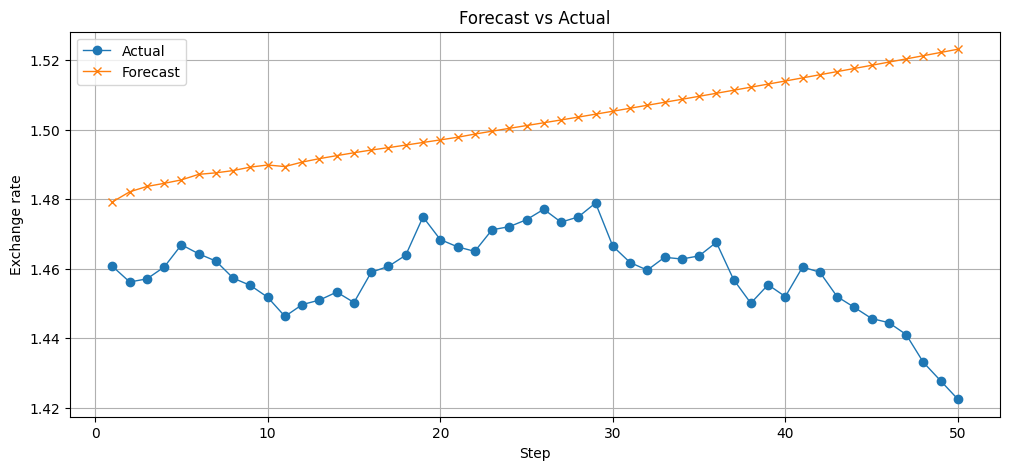

In [70]:
# Compare AUD forecast to test targets (inverse-transform test y then compute errors)
actual_scaled = testing_dict[aus_currency]['y']
actual = aus_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).reshape(-1)

# align lengths (forecast horizon may differ from test windows)
n = min(len(actual), len(aus_forecast_df))
fc = aus_forecast_df['AUSTRALIAN_DOLLAR_US$'].iloc[:n].values
act = actual[:n]

cmp_df = pd.DataFrame({'forecast': fc, 'actual': act}, index=range(1, n + 1))
cmp_df.index.name = 'step'

mae = np.mean(np.abs(fc - act))
rmse = np.sqrt(np.mean((fc - act) ** 2))
mape = np.mean(np.abs((fc - act) / act)) * 100

print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}, MAPE: {mape:.3f}%")

plt.figure(figsize=(12,5))
plt.plot(cmp_df.index, cmp_df['actual'], label='Actual', marker='o', linewidth=1)
plt.plot(cmp_df.index, cmp_df['forecast'], label='Forecast', marker='x', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Exchange rate')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()